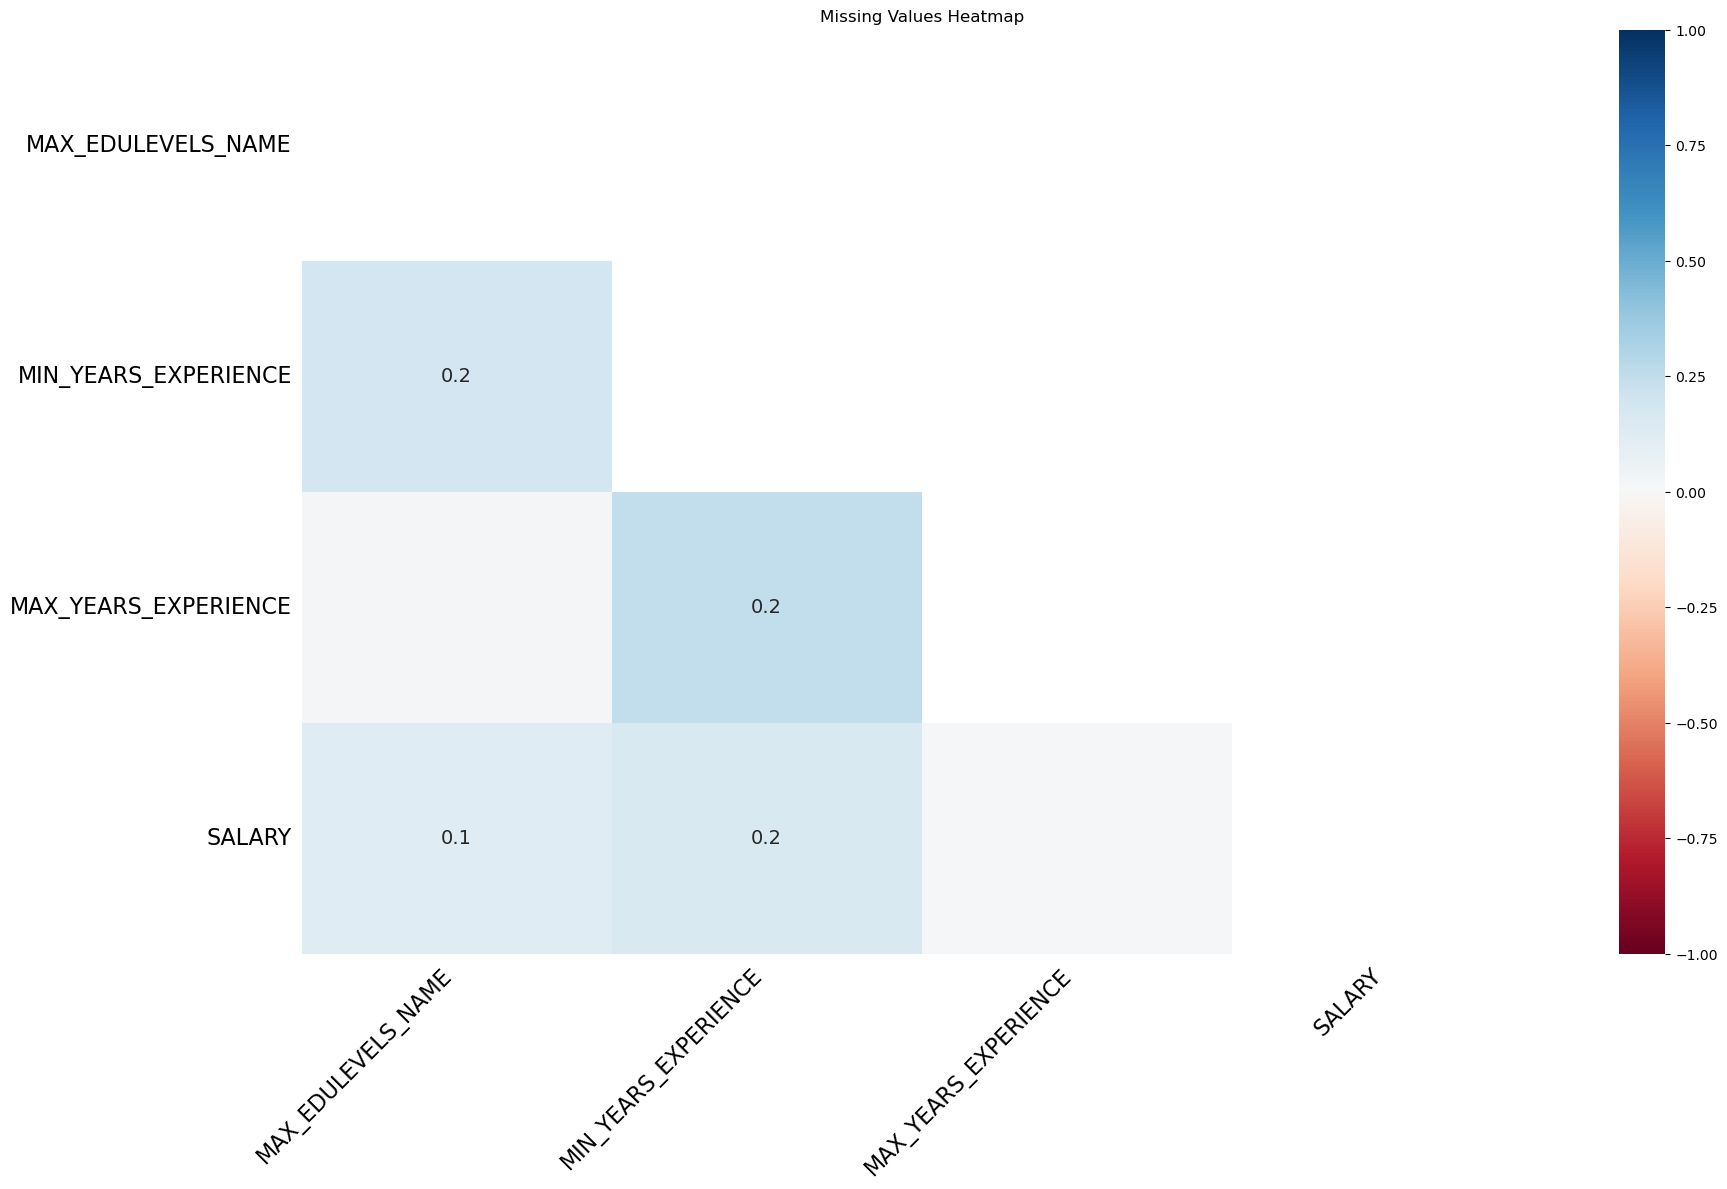

In [7]:

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import missingno as msno

df = pd.read_csv("data/lightcast_job_postings.csv")

columns_to_keep = [
    'COMPANY',  
    'LOCATION',
    'POSTED',              
    'MIN_EDULEVELS_NAME',   
    'MAX_EDULEVELS_NAME',       
    'MIN_YEARS_EXPERIENCE',
    'MAX_YEARS_EXPERIENCE',        
    'TITLE',               
    'SKILLS',                     
    'SPECIALIZED_SKILLS',       
    'CERTIFICATIONS',           
    'COMMON_SKILLS',            
    'SOFTWARE_SKILLS',        
    'SOC_2021_4_NAME',           
    'NAICS_2022_6',
    'NAICS2_NAME',              
    'REMOTE_TYPE_NAME',          
    'SALARY',
    'TITLE_NAME',
    'SKILLS_NAME',
    'SPECIALIZED_SKILLS_NAME'              
]

eda_data = df[columns_to_keep]

msno.heatmap(eda_data)
plt.title("Missing Values Heatmap")
plt.show()

In [8]:
eda_data.head()

,COMPANY,LOCATION,POSTED,MIN_EDULEVELS_NAME,MAX_EDULEVELS_NAME,MIN_YEARS_EXPERIENCE,MAX_YEARS_EXPERIENCE,TITLE,SKILLS,SPECIALIZED_SKILLS,...,COMMON_SKILLS,SOFTWARE_SKILLS,SOC_2021_4_NAME,NAICS_2022_6,NAICS2_NAME,REMOTE_TYPE_NAME,SALARY,TITLE_NAME,SKILLS_NAME,SPECIALIZED_SKILLS_NAME
0,894731,"{\n ""lat"": 33.20763,\n ""lon"": -92.6662674\n}",2024-06-02,Bachelor's degree,NaN,2.0,2.0,ET29C073C03D1F86B4,"[\n ""KS126DB6T061MHD7RTGQ"",\n ""KS126706DPFD3...","[\n ""KS126DB6T061MHD7RTGQ"",\n ""KS128006L3V0H...",...,"[\n ""KS126706DPFD3354M7YK"",\n ""KS1280B68GD79...","[\n ""KS440W865GC4VRBW6LJP"",\n ""KS13USA80NE38...",Data Scientists,441330,Retail Trade,[None],NaN,Enterprise Analysts,"[\n ""Merchandising"",\n ""Mathematics"",\n ""Pr...","[\n ""Merchandising"",\n ""Predictive Modeling""..."
1,133098,"{\n ""lat"": 44.3106241,\n ""lon"": -69.7794897\n}",2024-06-02,No Education Listed,NaN,3.0,3.0,ET21DDA63780A7DC09,"[\n ""KS122626T550SLQ7QZ1C"",\n ""KS123YJ6KVWC9...","[\n ""KS122626T550SLQ7QZ1C"",\n ""KS123YJ6KVWC9...",...,[],"[\n ""BGSBF3F508F7F46312E3"",\n ""ESEA839CED378...",Data Scientists,561320,Administrative and Support and Waste Managemen...,Remote,NaN,Oracle Consultants,"[\n ""Procurement"",\n ""Financial Statements"",...","[\n ""Procurement"",\n ""Financial Statements"",..."
2,39063746,"{\n ""lat"": 32.7766642,\n ""lon"": -96.7969879\n}",2024-06-02,Bachelor's degree,NaN,5.0,NaN,ET3037E0C947A02404,"[\n ""KS1218W78FGVPVP2KXPX"",\n ""ESF3939CE1F80...","[\n ""ESF3939CE1F80C10C327"",\n ""KS120GV6C72JM...",...,"[\n ""KS1218W78FGVPVP2KXPX"",\n ""BGS1ADAA36DB6...","[\n ""KS126HY6YLTB9R7XJC4Z""\n]",Data Scientists,524291,Finance and Insurance,[None],NaN,Data Analysts,"[\n ""Management"",\n ""Exception Reporting"",\n...","[\n ""Exception Reporting"",\n ""Data Analysis""..."
3,37615159,"{\n ""lat"": 33.4483771,\n ""lon"": -112.0740373\n}",2024-06-02,No Education Listed,NaN,3.0,NaN,ET2114E0404BA30075,"[\n ""KS123QX62QYTC4JF38H8"",\n ""KS7G6NP6R6L1H...","[\n ""KS123QX62QYTC4JF38H8"",\n ""KS441PQ64HT13...",...,"[\n ""KS7G6NP6R6L1H1SKFTSY"",\n ""KS1218W78FGVP...","[\n ""KS4409D76NW1S5LNCL18"",\n ""ESC7869CF7378...",Data Scientists,522110,Finance and Insurance,[None],NaN,Management Analysts,"[\n ""Exit Strategies"",\n ""Reliability"",\n ""...","[\n ""Exit Strategies"",\n ""User Story"",\n ""H..."
4,0,"{\n ""lat"": 37.6392595,\n ""lon"": -120.9970014\n}",2024-06-02,No Education Listed,NaN,NaN,NaN,ET0000000000000000,[],[],...,[],[],Data Scientists,999999,Unclassified Industry,[None],92500.0,Unclassified,[],[]


In [11]:

if "SALARY" in eda_data.columns:
    eda_data["SALARY"].fillna(eda_data["SALARY"].median(), inplace=True)
else:
    print("⚠️ Warning: 'SALARY' column not found in dataframe!")

if "COMPANY" in eda_data.columns:
    eda_data["COMPANY"].fillna("Unknown", inplace=True)
else:
    print("⚠️ Warning: 'COMPANY' column not found in dataframe!")

    # Fill numeric columns with mean
num_cols = eda_data.select_dtypes(include='number').columns
for col in num_cols:
    if eda_data[col].isnull().sum() > 0:
        eda_data[col].fillna(eda_data[col].mean(), inplace=True)

# Fill categorical columns with mode
cat_cols = eda_data.select_dtypes(include='object').columns
for col in cat_cols:
    if eda_data[col].isnull().sum() > 0:
        eda_data[col].fillna(eda_data[col].mode()[0], inplace=True)

print("✅ Remaining missing values filled based on column type.")


eda_data.dropna(thresh=len(eda_data) * 0.5, axis=1, inplace=True)


print("✅ Missing value handling complete.")

# delete duplicates
eda_data = eda_data.drop_duplicates(subset=["TITLE", "COMPANY", "LOCATION", "POSTED"])

print(eda_data.isnull().sum())

✅ Remaining missing values filled based on column type.
✅ Missing value handling complete.
COMPANY                    0
LOCATION                   0
POSTED                     0
MIN_EDULEVELS_NAME         0
MAX_EDULEVELS_NAME         0
MIN_YEARS_EXPERIENCE       0
MAX_YEARS_EXPERIENCE       0
TITLE                      0
SKILLS                     0
SPECIALIZED_SKILLS         0
CERTIFICATIONS             0
COMMON_SKILLS              0
SOFTWARE_SKILLS            0
SOC_2021_4_NAME            0
NAICS_2022_6               0
NAICS2_NAME                0
REMOTE_TYPE_NAME           0
SALARY                     0
TITLE_NAME                 0
SKILLS_NAME                0
SPECIALIZED_SKILLS_NAME    0
dtype: int64


/var/folders/pm/h80kxhdj497chd0j6d72z7km0000gn/T/ipykernel_11266/493597886.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  eda_data["SALARY"].fillna(eda_data["SALARY"].median(), inplace=True)
/var/folders/pm/h80kxhdj497chd0j6d72z7km0000gn/T/ipykernel_11266/493597886.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are s

In [12]:
eda_data.to_csv("data/eda_data.csv", index=False)